In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from copy import deepcopy
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import time
import gc
import scipy
from scipy.signal import butter, filtfilt, argrelextrema
from scipy.interpolate import interp1d
from mup import MuReadout, MuSGD, MuAdam
import mup as mup
from pathlib import Path

device = 'mps'


In [3]:
##### Smoothing features #####
def lower_envelope(x,y):
    minima_idx = argrelextrema(y, np.less, order=1)[0]
    x_sampled = x[minima_idx]
    y = y[minima_idx]
    interp = interp1d(x_sampled, y, kind='linear', fill_value='extrapolate')
    y = interp(x)
    return np.array([x, y]).transpose()

def upper_envelope(x,y):
    maxima_idx = argrelextrema(y, np.greater, order=2)[0]
    x_sampled = x[maxima_idx]
    y = y[maxima_idx]
    interp = interp1d(x_sampled, y, kind='linear', fill_value='extrapolate')
    y = interp(x)
    return np.array([x, y]).transpose()

def low_pass_filter(y, f_c, order = 5):
    b, a = butter(order, f_c, btype='low')
    return filtfilt(b,a,y)

def moving_average(arr, window_size=20):
    return np.convolve(arr, np.ones(window_size)/window_size, mode='valid')

def smooth_xy_for_plot(x, y, window_size=1):
    y_smooth = moving_average(y, window_size)
    # Truncate x to match
    x_smooth = x[:len(y_smooth)]
    return np.column_stack([x_smooth, y_smooth])


In [4]:
##### Load a dictionnary of curves related to the training of several models and plot interesting datas about the training dynamic #####

### LOAD ###
def load_data_dictionnary(model_file_name, date):
    """ Data contains are : training_loss, validation_loss, accuracy, kappa_training_loss, kappa_validation_loss, kappa_accuracy"""
    training_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/training_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    validation_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/validation_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    accuracy = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/accuracy_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_training_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_training_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_validation_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_validation_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_accuracy = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_accuracy_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    
    model_data_dictionnary = {'training loss' : training_loss, 'validation loss' : validation_loss, 'accuracy' : accuracy, 
                        'kappa training loss' : kappa_training_loss, 'kappa validation loss' : kappa_validation_loss,
                        'kappa accuracy' : kappa_accuracy}    
    
    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + 'fraction_minibatch' + model_file_name + '.txt') :
        fraction_minibatch = torch.load('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' + 'fraction_minibatch' + model_file_name + '.txt',  delimiter=",", skiprows=1)
        model_data_dictionnary['fraction minibatch'] = fraction_minibatch

    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/accuracy_of_' + date + '_' + model_file_name + '_last_layer_fine_tuned' +'.txt') :
        training_loss_fine_tuned = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/training_loss_of_' + date + '_' + model_file_name + '_last_layer_fine_tuned' + '.txt', delimiter=",", skiprows=1)
        validation_loss_fine_tuned = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/validation_loss_of_' + date + '_' + model_file_name + '_last_layer_fine_tuned' + '.txt', delimiter=",", skiprows=1)
        accuracy_fine_tuned = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/accuracy_of_' + date + '_' + model_file_name + '_last_layer_fine_tuned' + '.txt', delimiter=",", skiprows=1)
        model_data_dictionnary = model_data_dictionnary | {'fine tuned training loss' : training_loss_fine_tuned, 'fine tuned validation loss' : validation_loss_fine_tuned, 'fine tuned accuracy' : accuracy_fine_tuned}
    
    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_first_layer_weight_bias.pt') :
        weight_bias = torch.load('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_first_layer_weight_bias.pt')
        model_data_dictionnary = model_data_dictionnary | weight_bias
    
    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_first_layer_weight_bias_trajectory.pt') :
        weight_bias = torch.load('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_first_layer_weight_bias_trajectory.pt')
        model_data_dictionnary = model_data_dictionnary | {'layers trajectories' : {1 : weight_bias}}
    
    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_second_layer_weight_bias_trajectory.pt') :
        weight_bias = torch.load('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_second_layer_weight_bias_trajectory.pt')
        model_data_dictionnary['layers trajectories'] = model_data_dictionnary['layers trajectories'] | {2 : weight_bias}
        
    return model_data_dictionnary

def load_data_dictionnary_pre_29_05(model_file_name, date):
    """ Data contains are : training_loss, validation_loss, accuracy, kappa_training_loss, kappa_validation_loss, kappa_accuracy"""
    training_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/loss_training_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    validation_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/validation_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    accuracy = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/accuracy_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_training_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_loss_training_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_validation_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_loss_validation_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_accuracy = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_accuracy_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    
    model_data_dictionnary = {'training loss' : training_loss, 'validation loss' : validation_loss, 'accuracy' : accuracy, 
                        'kappa training loss' : kappa_training_loss, 'kappa validation loss' : kappa_validation_loss,
                        'kappa accuracy' : kappa_accuracy}
    return model_data_dictionnary

### CONVERGENCE SPEED ###

def convergence_speed(curve, ref_curve, delta = 1e-3,observation_rate=10):
    if np.size(np.where((curve - (np.max(ref_curve)-delta) > 0))[0]) > 0 :
        return np.where((curve - (np.max(ref_curve)-delta) > 0))[0][0]*observation_rate
    else : 
        return -1e8

def convergence_speed_plot(curve_dictionnary, color_list, marker_list, x_list, delta=1e-3, save=True, save_path = '', save_name_peculiarity=''):
    convergence_speed_dictionnary = deepcopy(curve_dictionnary)
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] = convergence_speed(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)
                    plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '13', markeredgecolor = color_list[n_hidden_units], markerfacecolor = 'None')       
                else : 
                    convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] = convergence_speed(curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)
                    plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '13', color = color_list[n_hidden_units])       
                 
    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(convergence_speed_dictionnary):
        legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units], marker='.', linestyle='None', label = n_hidden_units)]
        if i == 0:
            for type_of_training in convergence_speed_dictionnary[n_hidden_units]:
                if type_of_training != 'First trained + Last fine tuned' :
                    legend_training_type += [Line2D([0], [0], markeredgecolor= 'black', markerfacecolor='None', marker = marker_list[type_of_training], linestyle = 'None', label = type_of_training)]
                else : 
                    legend_training_type += [Line2D([0], [0], color= 'black', marker = marker_list[type_of_training], linestyle = 'None', label = type_of_training)]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of layers')
    plt.ylabel('Number of iterations')
    plt.title('Convergence speed of training \nfor the different architectures and types of training', pad = 20)
    y_max = np.max([convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] 
                for n_hidden_units in convergence_speed_dictionnary
                for type_of_training in convergence_speed_dictionnary[n_hidden_units]
                for architecture in convergence_speed_dictionnary[n_hidden_units][type_of_training]])
    plt.ylim(-0.05*y_max, 1.05*y_max)
    plt.xticks([x for key, x in x_list.items()])
    plt.grid()
    if save :
        plt.savefig(save_path + 'convergence_speed_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'convergence_speed_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return

def normalized_convergence_speed_plot(curve_dictionnary, color_list, marker_list, x_list, delta=1e-3, save=True, save_path = '', save_name_peculiarity=''):
    convergence_speed_dictionnary = deepcopy(curve_dictionnary)
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] = convergence_speed(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)/convergence_speed(curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)
                    if type_of_training == 'Reference':
                        plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', color = 'black')
                    else :
                        plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', markerfacecolor = 'none', markeredgecolor = color_list[n_hidden_units])
                else :
                    convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] = convergence_speed(curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)/convergence_speed(curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)
                    plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', markerfacecolor = color_list[n_hidden_units], markeredgecolor = color_list[n_hidden_units])

    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(convergence_speed_dictionnary):
        legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units], marker='.', linestyle='None', label = n_hidden_units)]
        if i == 0:
            for type_of_training in convergence_speed_dictionnary[n_hidden_units]:
                if type_of_training != 'First trained + Last fine tuned' :
                    legend_training_type += [Line2D([0], [0], marker = marker_list[type_of_training], linestyle='None', markeredgecolor='black', markerfacecolor='None', label = type_of_training)]
                else : 
                    legend_training_type += [Line2D([0], [0], marker = marker_list[type_of_training], linestyle='None', markeredgecolor='black', markerfacecolor='black', label = type_of_training)]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of layers')
    plt.ylabel('Number of iterations')
    plt.title('Normalized convergence speed of training \nfor different architectures and types of training', pad = 20)
    y_max = np.max([convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] 
                for n_hidden_units in convergence_speed_dictionnary
                for type_of_training in convergence_speed_dictionnary[n_hidden_units]
                for architecture in convergence_speed_dictionnary[n_hidden_units][type_of_training]])
    plt.ylim(-0.1, y_max + 0.1)
    plt.xticks([x for key, x in x_list.items()])
    plt.grid()
    if save :
        plt.savefig(save_path + 'normalized_convergence_speed_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'normalized_convergence_speed_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return

### MAXIMUM ACCURACY ###

def max_accuracy_plot(curve_dictionnary, color_list, marker_list, x_list, save=True, save_path = '', save_name_peculiarity='') :
    max_accuracy_dictionnary = deepcopy(curve_dictionnary)
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture] = np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1])
                    plt.plot(x_list[architecture], max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units])
                else : 
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture] = np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned accuracy'][:,1])
                    plt.plot(x_list[architecture], max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', markerfacecolor = color_list[n_hidden_units], markeredgecolor = color_list[n_hidden_units])

    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(max_accuracy_dictionnary):
        legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units], marker = '.', linestyle='None', label = n_hidden_units)]
        if i == 0:
            for type_of_training in max_accuracy_dictionnary[n_hidden_units]:
                if type_of_training != 'First trained + Last fine tuned' :
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                else : 
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of layers')
    plt.ylabel('Accuracy')
    plt.title('Maximum accuracy for\n the different architectures and types of training', pad = 20)
    y_max = np.max([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]])
    y_min = np.min([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]])
    plt.ylim(y_min - 0.01, y_max + 0.01)
    plt.xticks([x for key, x in x_list.items()])
    plt.grid()
    if save :
        plt.savefig(save_path + 'max_accuracy_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'max_accuracy_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return

### ACCURACY TRAJECTORY ###

def accuracy_trajectory_plot(curve_dictionnary, color_list, marker_list, x_lim = None, y_lim = None, save=True, save_path = '', save_name_peculiarity='', observation_rate = 10) :
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    accuracy = curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy']
                    x_max = x_lim[1] if x_lim is not None else curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,0][-1]*observation_rate
                    accuracy[:,1] = low_pass_filter(accuracy[:,1], 0.10)
                    len_accuracy = len(accuracy[accuracy[:,0] < x_max])
                    plt.plot(accuracy[:,0], accuracy[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_accuracy/10), color = color_list[n_hidden_units][architecture])
                            
                else :
                    accuracy = curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned accuracy']
                    plt.plot(accuracy[:,0], accuracy[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], color = color_list[n_hidden_units][architecture])
    labels=[]
    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(curve_dictionnary):
        for j, type_of_training in enumerate(curve_dictionnary[n_hidden_units]):
            for k, architecture in enumerate(curve_dictionnary[n_hidden_units][type_of_training]):
                if i == 0 and k == 0:
                    if type_of_training != 'First trained + Last fine tuned' :
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                    else : 
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                if np.sum([n_hidden_units + ' - ' + architecture==label for label in labels])==0:    
                    legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units][architecture], linewidth=5, label = n_hidden_units + ' - ' + architecture)]
                    labels += [n_hidden_units + ' - ' + architecture]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during training for\n the different architectures and types of training', pad = 20)
    x_max = np.max([np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,0])
                    for n_hidden_units in curve_dictionnary
                    for type_of_training in curve_dictionnary[n_hidden_units]
                    for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if x_lim == None else x_lim[1]
    plt.xlim(-100, x_max)
    y_max = np.max([np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1])
                for n_hidden_units in curve_dictionnary
                for type_of_training in curve_dictionnary[n_hidden_units]
                for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[1] 
    y_min = np.min([np.min(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1])
                for n_hidden_units in curve_dictionnary
                for type_of_training in curve_dictionnary[n_hidden_units]
                for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[0] 
    
    plt.ylim(y_min - 0.01, y_max + 0.01)
    plt.grid()
    if save :
        plt.savefig(save_path + 'accuracy_trajectories' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'accuracy_trajectories' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return

### LOSS TRAJECTORY ###

def loss_trajectory_plot(curve_dictionnary, color_list, marker_list, x_lim = None, y_lim = None, save=True, save_path = '', save_name_peculiarity='', observation_rate = 10) :
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned':
                    training_loss = curve_dictionnary[n_hidden_units][type_of_training][architecture]['training loss']
                    validation_loss = curve_dictionnary[n_hidden_units][type_of_training][architecture]['validation loss']
                    training_loss[:,1] = low_pass_filter(training_loss[:,1], 0.30)
                    validation_loss[:,1] = low_pass_filter(validation_loss[:,1], 0.30)
                    x_max = x_lim[1] if x_lim is not None else training_loss[:,0][-1]*observation_rate
                    len_training_loss = len(training_loss[training_loss[:,0] < x_max])
                    plt.plot(training_loss[:,0], training_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_training_loss/10), color = color_list[n_hidden_units][architecture])
                    x_max = x_lim[1] if x_lim is not None else validation_loss[:,0][-1]*observation_rate
                    len_validation_loss = len(validation_loss[validation_loss[:,0] < x_max])
                    plt.plot(validation_loss[:,0], validation_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_validation_loss/10), linestyle = ':', color = color_list[n_hidden_units][architecture])
        
                else : 
                    training_loss = curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned training loss']
                    plt.plot(training_loss[:,0], training_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], color = color_list[n_hidden_units][architecture])
                    validation_loss = curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned validation loss']
                    plt.plot(validation_loss[:,0], validation_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], linestyle = ':', color = color_list[n_hidden_units][architecture])
    labels=[]
    legend_hu = []
    legend_training_type = []
    legend_loss_type = [Line2D([0], [0], color = 'black', label = 'Training loss'), 
                        Line2D([0], [0], color = 'black', linestyle = ':', label = 'Validation_loss')]
    for i, n_hidden_units in enumerate(curve_dictionnary):
        for j, type_of_training in enumerate(curve_dictionnary[n_hidden_units]): 
            for k, architecture in enumerate(curve_dictionnary[n_hidden_units][type_of_training]):
                if i == 0 and k == 0:
                    if type_of_training != 'First trained + Last fine tuned' :
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                    else : 
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                if np.sum([n_hidden_units + ' - ' + architecture==label for label in labels])==0:    
                    legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units][architecture], linewidth=5, label = n_hidden_units + ' - ' + architecture)]
                    labels += [n_hidden_units + ' - ' + architecture]
    legend_elements = legend_loss_type + legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.title('Loss during training for \nthe different architectures and types of training', pad = 20)
    x_max = np.max([np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['training loss'][:,0])
                    for n_hidden_units in curve_dictionnary
                    for type_of_training in curve_dictionnary[n_hidden_units]
                    for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if x_lim == None else x_lim[1]
    plt.xlim(0, x_max)
    y_max = np.max([np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['training loss'][:,1]) 
                for n_hidden_units in curve_dictionnary
                for type_of_training in curve_dictionnary[n_hidden_units]
                for architecture in curve_dictionnary[n_hidden_units][type_of_training]]
                + [np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['validation loss'][:,1])
                for n_hidden_units in curve_dictionnary
                for type_of_training in curve_dictionnary[n_hidden_units]
                for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[1]    
    plt.ylim(-0.01, y_max + 0.01)
    plt.grid()
    if save :
        plt.savefig(save_path + 'loss_trajectories' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'loss_trajectories' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return





In [19]:
##### STATISTICS - Load a dictionnary of curves related to the training of several samples of several models and plot interesting datas about the training dynamic #####


### LOAD ###

def load_multi_saves_data_dictionnary(model_file_name, date):
    """
    Charge les résultats moyens (loss, accuracy, etc.)
    """
    model_path = Path('Classifiers') / date / f"{date}_{model_file_name}"
    model_data_dictionnary = {}
    save_index = 1

    if not model_path.exists():
        print(f"[WARNING] Dossier inexistant : {model_path}")
        return model_data_dictionnary

    for save in model_path.iterdir():
        if not save.is_dir():
            continue

        save_data = {}
        figures_path = save / 'figures'

        # Essayer de charger les fichiers principaux (avec test)
        for metric in ['training_loss', 'validation_loss', 'accuracy',
                       'kappa_training_loss', 'kappa_validation_loss', 'kappa_accuracy']:
            file_path = figures_path / f"{metric}_of_{date}_{model_file_name}.txt"
            if file_path.exists():
                save_data[metric.replace('_', ' ')] = np.loadtxt(file_path, delimiter=",", skiprows=1)

        # Essayer de charger les fichiers "last_layer_fine_tuned"
        for metric in ['training_loss', 'validation_loss', 'accuracy']:
            file_path = figures_path / f"{metric}_of_{date}_{model_file_name}_last_layer_fine_tuned.txt"
            if file_path.exists():
                save_data[f"fine tuned {metric.replace('_', ' ')}"] = np.loadtxt(file_path, delimiter=",", skiprows=1)

        # Essayer de charger les poids/biais
        first_layer_path = save / f"{date}_{model_file_name}_first_layer_weight_bias.pt"
        if first_layer_path.exists():
            try:
                weight_bias = torch.load(first_layer_path)
                save_data = save_data | weight_bias
            except Exception as e:
                print(f"[ERROR] Impossible de charger {first_layer_path} : {e}")

        # Essayer de charger les trajectoires
        layers_trajectories = {}

        first_traj_path = save / f"{date}_{model_file_name}_first_layer_weight_bias_trajectory.pt"
        if first_traj_path.exists():
            try:
                layers_trajectories[1] = torch.load(first_traj_path)
            except Exception as e:
                print(f"[ERROR] Impossible de charger {first_traj_path} : {e}")

        second_traj_path = save / f"{date}_{model_file_name}_second_layer_weight_bias_trajectory.pt"
        if second_traj_path.exists():
            try:
                layers_trajectories[2] = torch.load(second_traj_path)
            except Exception as e:
                print(f"[ERROR] Impossible de charger {second_traj_path} : {e}")

        if layers_trajectories:
            save_data['layers trajectories'] = layers_trajectories

        # Stocker dans le dictionnaire final si on a trouvé des données
        if save_data:
            model_data_dictionnary[f'save {save_index}'] = save_data
            save_index += 1

    return model_data_dictionnary


## If several kappa = log(n)/log(d) ##

def load_multi_kappa_multi_saves_data_dictionnary(model_file_name, date):
    """
    Charge les résultats moyens (loss, accuracy, etc.) sous la forme d'un dictionnaire [kappa][save_index][metric]
    """
    model_path = Path('Classifiers') / date / f"{date}_{model_file_name}"
    model_data_dictionnary = {}
    save_index = 1

    if not model_path.exists():
        print(f"[WARNING] Dossier inexistant : {model_path}")
        return model_data_dictionnary

    for kappa in model_path.iterdir():
        model_data_dictionnary[kappa] = {}

        for save in (model_path / kappa).iterdir():
            if not save.is_dir():
                continue

            save_data = {}
            figures_path = save / 'figures'

            # Essayer de charger les fichiers principaux (avec test)
            for metric in ['training_loss', 'validation_loss', 'accuracy',
                        'kappa_training_loss', 'kappa_validation_loss', 'kappa_accuracy']:
                file_path = figures_path / f"{metric}_of_{date}_{model_file_name}.txt"
                if file_path.exists():
                    save_data[metric.replace('_', ' ')] = np.loadtxt(file_path, delimiter=",", skiprows=1)

            # Essayer de charger les fichiers "last_layer_fine_tuned"
            for metric in ['training_loss', 'validation_loss', 'accuracy']:
                file_path = figures_path / f"{metric}_of_{date}_{model_file_name}_last_layer_fine_tuned.txt"
                if file_path.exists():
                    save_data[f"fine tuned {metric.replace('_', ' ')}"] = np.loadtxt(file_path, delimiter=",", skiprows=1)

            # Essayer de charger les poids/biais
            first_layer_path = save / f"{date}_{model_file_name}_first_layer_weight_bias.pt"
            if first_layer_path.exists():
                try:
                    weight_bias = torch.load(first_layer_path)
                    save_data = save_data | weight_bias
                except Exception as e:
                    print(f"[ERROR] Impossible de charger {first_layer_path} : {e}")

            # Essayer de charger les trajectoires
            layers_trajectories = {}

            first_traj_path = save / f"{date}_{model_file_name}_first_layer_weight_bias_trajectory.pt"
            if first_traj_path.exists():
                try:
                    layers_trajectories[1] = torch.load(first_traj_path)
                except Exception as e:
                    print(f"[ERROR] Impossible de charger {first_traj_path} : {e}")

            second_traj_path = save / f"{date}_{model_file_name}_second_layer_weight_bias_trajectory.pt"
            if second_traj_path.exists():
                try:
                    layers_trajectories[2] = torch.load(second_traj_path)
                except Exception as e:
                    print(f"[ERROR] Impossible de charger {second_traj_path} : {e}")

            if layers_trajectories:
                save_data['layers trajectories'] = layers_trajectories

            # Stocker dans le dictionnaire final si on a trouvé des données
            if save_data:
                model_data_dictionnary[kappa][f'save {save_index}'] = save_data
                save_index += 1

    return model_data_dictionnary

### CONVERT SEVERAL SAMPLES into ONE MEAN CURVE (+ ERROR) ###

def convert_to_statistical_data_dictionnary(model_data_dictionnary, outlier_filter=True):
    """
    model_data_dictionnary structure :
        { 'save 1': { 'metric_name': array, ... }, ... }
    Returns :
        { 'mean': {metric_name: array}, 'error': {metric_name: array} }
    """
    # Initialiser dictionnaires résultat
    statistical_curve = {'mean': {}, 'error': {}}

    # Pour chaque metric, construire la pile de toutes les saves alignées
    metrics = list(next(iter(model_data_dictionnary.values())).keys())
    n_saves = len(model_data_dictionnary)

    for metric in metrics:
            # Trouver la longueur minimale sur toutes les saves et metrics
        min_length = np.min([
            model_data_dictionnary[save][metric].shape[0]
            for save in model_data_dictionnary
        ])
        # Stack des valeurs coupées à min_length
        values_list = []
        for save in model_data_dictionnary:
            values = model_data_dictionnary[save][metric][:min_length, 1]
            values_list.append(values)
        
        # Transformer en array (n_saves x min_length)
        values_array = np.vstack(values_list)

        # Moyenne et erreur-type absolue
        mean_values = np.mean(values_array, axis=0)
        error_values = np.std(values_array, axis=0) / np.sqrt(n_saves)  # erreur-type (SEM)

        # On suppose que l'axe X est le même (prend celui du premier save)
        x_axis = model_data_dictionnary[next(iter(model_data_dictionnary))][metric][:min_length, 0]

        # Stocker résultat
        statistical_curve['mean'][metric] = np.column_stack((x_axis, mean_values))
        statistical_curve['error'][metric] = error_values/2

        if outlier_filter:
            outliers_indices = np.where(statistical_curve['error'][metric] > 0.03)
            for outlier_index in outliers_indices :
                statistical_curve['error'][metric][outlier_index] = 0
    return statistical_curve


### STATISTICAL ACCURACY ###

# The statistical curves are gathered in a statistical curves dictionnary

def statistical_accuracy_trajectory_plot(statistical_curve_dictionnary, n_saves, color_list, marker_list, x_lim = None, y_lim = None, save=True, save_path = '', save_name_peculiarity='', observation_rate = 10) :
    for n_hidden_units in statistical_curve_dictionnary:
        for type_of_training in statistical_curve_dictionnary[n_hidden_units] :
            for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    accuracy = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['accuracy']
                    for i in range(1,len(accuracy[:,1])):
                        if accuracy[i,1]<accuracy[i-1,1]-0.005:
                            accuracy[i,1] = accuracy[i-1,1]
                    accuracy_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['accuracy']
                    x_max = x_lim[1] if x_lim is not None else accuracy[:,0][-1]*observation_rate
                    accuracy[:,1] = low_pass_filter(accuracy[:,1], 0.1)
                    len_accuracy = len(accuracy[accuracy[:,0] < x_max])
                    # plt.errorbar(accuracy[:,0], accuracy[:,1], yerr=accuracy_error, fmt='o', capsize=2, marker = marker_list[type_of_training], markersize = '4', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_accuracy/10), color = color_list[n_hidden_units][architecture])
                    plt.errorbar(accuracy[:,0], accuracy[:,1], capsize=2, marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_accuracy/10), color = color_list[n_hidden_units][architecture])
                else :
                    accuracy = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['fine tuned accuracy']
                    for i in range(1,len(accuracy[:,1])):
                        if accuracy[i,1]<accuracy[i-1,1]-0.005:
                            accuracy[i,1] = accuracy[i-1,1]
                    accuracy_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['fine tuned accuracy']
                    x_max = x_lim[1] if x_lim is not None else statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['fine tuned accuracy'][:,0][-1]
                    len_accuracy = len(accuracy[accuracy[:,0] < x_max])
                    # plt.errorbar(accuracy[:,0], accuracy[:,1], yerr=accuracy_error, fmt='o', marker = marker_list[type_of_training], markersize = '4', markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], color = color_list[n_hidden_units][architecture])
                    plt.errorbar(accuracy[:,0], accuracy[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = color_list[n_hidden_units][architecture], markevery = int(len_accuracy/10), markeredgecolor = color_list[n_hidden_units][architecture], color = color_list[n_hidden_units][architecture])
    
    labels=[]
    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(statistical_curve_dictionnary):
        for j, type_of_training in enumerate(statistical_curve_dictionnary[n_hidden_units]):
            for k, architecture in enumerate(statistical_curve_dictionnary[n_hidden_units][type_of_training]):
                if i == 0 and k == 0:
                    if type_of_training != 'First trained + Last fine tuned' :
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                    else : 
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                if np.sum([n_hidden_units + ' - ' + architecture==label for label in labels])==0:    
                    legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units][architecture], linewidth=5, label = n_hidden_units + ' - ' + architecture)]
                    labels += [n_hidden_units + ' - ' + architecture]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of iterations')
    plt.ylabel('Accuracy')
    plt.title(f'Mean accuracy during training for\n the different architectures and types of training\non N = {n_saves} samples', pad = 20)
    x_max = np.max([np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['accuracy'][:,0])
                    for n_hidden_units in statistical_curve_dictionnary
                    for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                    for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if x_lim == None else x_lim[1]
    plt.xlim(-100, x_max)
    y_max = np.max([np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['accuracy'][:,1])
                for n_hidden_units in statistical_curve_dictionnary
                for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[1] 
    y_min = np.min([np.min(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['accuracy'][:,1])
                for n_hidden_units in statistical_curve_dictionnary
                for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[0] 
    
    plt.ylim(y_min - 0.01, y_max + 0.01)
    plt.grid()
    if save :
        plt.savefig(save_path + 'accuracy_trajectories_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'accuracy_trajectories_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return


### STATISTICAL LOSS ###

def statistical_loss_trajectory_plot(statistical_curve_dictionnary, n_saves, color_list, marker_list, x_lim = None, y_lim = None, save=True, save_path = '', save_name_peculiarity='', observation_rate = 10) :
    for n_hidden_units in statistical_curve_dictionnary:
        for type_of_training in statistical_curve_dictionnary[n_hidden_units] :
            for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned':
                    training_loss = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['training loss']
                    training_loss_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['training loss']
                    validation_loss = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['validation loss']
                    validation_loss_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['validation loss']
                    # training_loss[:,1] = low_pass_filter(training_loss[:,1], 0.30)
                    # validation_loss[:,1] = low_pass_filter(validation_loss[:,1], 0.30)
                    x_max = x_lim[1] if x_lim is not None else training_loss[:,0][-1]*observation_rate
                    len_training_loss = len(training_loss[training_loss[:,0] < x_max])
                    # plt.errorbar(training_loss[:,0], training_loss[:,1], training_loss_error, marker = marker_list[type_of_training], markersize = '4', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_training_loss/10), color = color_list[n_hidden_units][architecture])
                    plt.errorbar(training_loss[:,0], training_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_training_loss/10), color = color_list[n_hidden_units][architecture])

                    x_max = x_lim[1] if x_lim is not None else validation_loss[:,0][-1]*observation_rate
                    len_validation_loss = len(validation_loss[validation_loss[:,0] < x_max])
                    # plt.errorbar(validation_loss[:,0], validation_loss[:,1], validation_loss_error, marker = marker_list[type_of_training], markersize = '4', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_validation_loss/10), linestyle = ':', color = color_list[n_hidden_units][architecture])
                    plt.errorbar(validation_loss[:,0], validation_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_validation_loss/10), linestyle = ':', color = color_list[n_hidden_units][architecture])

                else : 
                    training_loss = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['fine tuned training loss']
                    training_loss_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['fine tuned training loss']
                    x_max = x_lim[1] if x_lim is not None else training_loss[:,0][-1]*observation_rate
                    len_training_loss = len(training_loss[training_loss[:,0] < x_max])
                    plt.errorbar(training_loss[:,0], training_loss[:,1], training_loss_error, marker = marker_list[type_of_training], markersize = '11',
                                  markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], 
                                  markevery = int(len_validation_loss/10), color = color_list[n_hidden_units][architecture])
                    x_max = x_lim[1] if x_lim is not None else validation_loss[:,0][-1]*observation_rate
                    len_training_loss = len(validation_loss[validation_loss[:,0] < x_max])
                    validation_loss = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['fine tuned validation loss']
                    validation_loss_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['fine tuned validation loss']
                    plt.errorbar(validation_loss[:,0], validation_loss[:,1], validation_loss_error, marker = marker_list[type_of_training], markersize = '11',
                                  markerfacecolor = color_list[n_hidden_units][architecture], markevery = int(len_validation_loss/10), 
                                  
                                  markeredgecolor = color_list[n_hidden_units][architecture], linestyle = ':', color = color_list[n_hidden_units][architecture])
    labels=[]
    legend_hu = []
    legend_training_type = []
    legend_loss_type = [Line2D([0], [0], color = 'black', label = 'Training loss'), 
                        Line2D([0], [0], color = 'black', linestyle = ':', label = 'Validation_loss')]
    for i, n_hidden_units in enumerate(statistical_curve_dictionnary):
        for j, type_of_training in enumerate(statistical_curve_dictionnary[n_hidden_units]): 
            for k, architecture in enumerate(statistical_curve_dictionnary[n_hidden_units][type_of_training]):
                if i == 0 and k == 0:
                    if type_of_training != 'First trained + Last fine tuned' :
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                    else : 
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                if np.sum([n_hidden_units + ' - ' + architecture==label for label in labels])==0:    
                    legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units][architecture], linewidth=5, label = n_hidden_units + ' - ' + architecture)]
                    labels += [n_hidden_units + ' - ' + architecture]
    legend_elements = legend_loss_type + legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.title(f'Mean loss during training for \nthe different architectures and types of training\non N = {n_saves} samples', pad = 20)
    x_max = np.max([np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['training loss'][:,0])
                    for n_hidden_units in statistical_curve_dictionnary
                    for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                    for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if x_lim == None else x_lim[1]
    plt.xlim(0, x_max)
    y_max = np.max([np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['training loss'][:,1]) 
                for n_hidden_units in statistical_curve_dictionnary
                for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]
                + [np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['validation loss'][:,1])
                for n_hidden_units in statistical_curve_dictionnary
                for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[1]    
    plt.ylim(-0.01, y_max + 0.01)
    plt.grid()
    if save :
        plt.savefig(save_path + 'loss_trajectories' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'loss_trajectories' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return


### STATISTICAL MAXIMUM ACCURACY ###

def statistical_max_accuracy_plot(multi_save_data_dictionnary, color_list, marker_list, save_file=True, save_path = '', save_name_peculiarity='') :
    x_list = {'2 layers' : 2, '3 layers' : 3, '4 layers' : 4}
    max_accuracy_dictionnary = deepcopy(multi_save_data_dictionnary)
    for n_hidden_units in multi_save_data_dictionnary:
        for type_of_training in multi_save_data_dictionnary[n_hidden_units] :
            for architecture in multi_save_data_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] = np.mean([np.max(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][save]['accuracy'][:,1]) for save in multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture]])
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['error'] = np.sqrt(np.mean([(max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] - np.max(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][save]['accuracy'][:,1]))**2 for save in multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture]]))
                    plt.errorbar(x_list[architecture], max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'], 
                                 yerr=max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['error'], fmt=marker_list[type_of_training], 
                                 ecolor = color_list[n_hidden_units], capsize=2,
                                 markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units])
                    
                else : 
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] = np.mean([np.max(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][save]['fine tuned accuracy'][:,1]) for save in multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture]])
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['error'] = np.sqrt(np.mean([(max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] - np.max(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][save]['fine tuned accuracy'][:,1]))**2 for save in multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture]]))
                    plt.errorbar(x_list[architecture], max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'], 
                                 yerr=max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['error'], fmt=marker_list[type_of_training], 
                                 ecolor = color_list[n_hidden_units], capsize=2,
                                 markersize = '11', markerfacecolor = color_list[n_hidden_units], markeredgecolor = color_list[n_hidden_units])

    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(max_accuracy_dictionnary):
        legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units], marker = '.', linestyle='None', label = n_hidden_units)]
        if i == 0:
            for type_of_training in max_accuracy_dictionnary[n_hidden_units]:
                if type_of_training != 'First trained + Last fine tuned' :
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                else : 
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of layers')
    plt.ylabel('Accuracy')
    plt.title(f'Mean maximum accuracy for\n the different architectures and types of training\non N = {len(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture])} samples', pad = 20)
    y_max = np.max([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]])
    y_min = np.min([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]])
    plt.ylim(y_min - 0.01, y_max + 0.01)
    plt.xticks([x for key, x in x_list.items()])
    plt.grid()
    if save_file :
        plt.savefig(save_path + 'max_accuracy_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'max_accuracy_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return


    ## As a function of kappa = log(n)/log(d) ##

def statistical_kappa_max_accuracy_plot(multi_kappa_multi_save_data_dictionnary, color_list, marker_list, save_file=True, save_path = '', save_name_peculiarity='') :    
    max_accuracy_dictionnary = deepcopy(multi_kappa_multi_save_data_dictionnary)
    for n_hidden_units in multi_kappa_multi_save_data_dictionnary:
        for type_of_training in multi_kappa_multi_save_data_dictionnary[n_hidden_units] :
            for architecture in multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training]:
                x_list = [int(kappa[8:]) for kappa in multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training]]
                for kappa in multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture]: 
                    if type_of_training != 'First trained + Last fine tuned' :
                        max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][kappa]['mean'] = np.mean([np.max(multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][kappa][save]['accuracy'][:,1]) 
                                                                                                                           for save in multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][kappa]])
                        max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][kappa]['error'] = np.sqrt(np.mean([(max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][kappa]['mean'] 
                                                                                                                                     - np.max(multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][kappa][save]['accuracy'][:,1]))**2 
                                                                                                                                     for save in multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][kappa]]))
                        
                    else : 
                        max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][kappa]['mean'] = np.mean([np.max(multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][kappa][save]['fine tuned accuracy'][:,1])
                                                                                                                                    for save in multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][kappa]])
                        max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][kappa]['error'] = np.sqrt(np.mean([(max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][kappa]['mean']
                                                                                                                                      - np.max(multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][kappa][save]['fine tuned accuracy'][:,1]))**2
                                                                                                                                     for save in multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][kappa]]))
                                    
                if type_of_training != 'First trained + Last fine tuned' :
                    plt.errorbar(x_list, max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][:]['mean'], 
                                                    yerr=max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][:]['error'], fmt=marker_list[type_of_training], 
                                                    ecolor = color_list[n_hidden_units], capsize=2,
                                                    markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units])
                
                else :
                    plt.errorbar(x_list[architecture], max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][:]['mean'], 
                                yerr=max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][:]['error'], fmt=marker_list[type_of_training], 
                                ecolor = color_list[n_hidden_units], capsize=2,
                                markersize = '11', markerfacecolor = color_list[n_hidden_units], markeredgecolor = color_list[n_hidden_units])

    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(max_accuracy_dictionnary):
        legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units], marker = '.', linestyle='None', label = n_hidden_units)]
        if i == 0:
            for type_of_training in max_accuracy_dictionnary[n_hidden_units]:
                if type_of_training != 'First trained + Last fine tuned' :
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                else : 
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of layers')
    plt.ylabel('Accuracy')
    plt.title(f'Mean maximum accuracy for\n the different architectures and types of training\ndepending on the number of datas\non N = {len(multi_kappa_multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][kappa])} samples', pad = 20)
    y_max = np.max([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][kappa]['mean'] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]
                for kappa in max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]])
    y_min = np.min([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture][kappa]['mean'] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]
                for kappa in max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]])
    plt.ylim(y_min - 0.01, y_max + 0.01)
    plt.xticks([x for key, x in x_list.items()])
    plt.grid()
    if save_file :
        plt.savefig(save_path + 'max_accuracy_depending_on_kappa_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'max_accuracy_depending_on_kappa_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return

In [6]:
##### Features overlap during training ###

def layer_representation(weight_1, bias_1, weight_2, bias_2, inputs, deep_layer_inputs, type, layer_rank):
    if layer_rank==1 :
        if type == 'preactivation':
            layer_1 = torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1 # shape (d1, n)
            layer_2 = torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2 # shape (d1, n)   
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1) # shape (d1, n, t)
            layer_2 = torch.relu(torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2) # shape (d1, n, t)
    else :
        if type == 'preactivation':
            layer_1 = torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1 # shape (d1, n)
            layer_2 = torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2 # shape (d1, n)   
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1) # shape (d1, n, t)
            layer_2 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2) # shape (d1, n, t)

    column_norm_layer_1 = layer_1.norm(dim=0).unsqueeze(0) # shape (1,n,t)
    column_norm_layer_2 = layer_2.norm(dim=0).unsqueeze(0)  # shape (1,n,t)
    norm_cross_matrix_layer = torch.einsum('int,imt->nmt', column_norm_layer_1, column_norm_layer_2) # shape (n,n,t)
    cross_scalar_product_matrix_layer = torch.einsum('qnt,qmt->nmt', layer_1, layer_2)
    
    normalized_cross_scalar_product_matrix_layer = (cross_scalar_product_matrix_layer / norm_cross_matrix_layer)
    return normalized_cross_scalar_product_matrix_layer, layer_1, layer_2

def representation_overlap_trajectories(model_1, model_2, x_validation, save_path, architecture, add_to_title=''):
    x_validation = x_validation.to(device)
    min_time = np.min([len(model_1['layers trajectories'][1]), len(model_2['layers trajectories'][1])])
    print(min_time)
    
    overlap_dico = {'normalized_cross_scalar_product_matrix_trace_trajectory' : 
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Expectation of the cosine similarity between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}},
                    'cross_scalar_product_matrix_trace_variance_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Variance of the cosine similarity between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Var [$\cos(\theta)$]"}},
                    'arccos_product_matrix_trace_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Mean angle between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\theta$"}},
                    'max_normalized_cross_scalar_product_matrix_trace_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Maximum cosine similarity between the representations\n of ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Max ($[\cos(\theta))$]"}}}

    normalized_cross_scalar_product_matrix = {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}
    color_list = {1 : {'preactivation' : 'blue', 'hidden' : 'green'}, 2 : {'preactivation' : 'orange', 'hidden' : 'red'}}

    label_list = {1 : {'preactivation' : r"$(W_1.x^{\top})^{\top}.(W_1'.x^{\top})$", 'hidden' : r"$(\sigma(W_1.x^{\top}))^{\top}.(\sigma(W_1'.x^{\top}))$"},
                  2 : {'preactivation' : r"$(W_2\sigma(W_1.x^{\top}))^{\top}.(W_2'\sigma(W_1'.x^{\top}))$", 'hidden' : r"$(\sigma(W_2\sigma(W_1.x^{\top})))^{\top}.(\sigma(W_2'\sigma(W_1'.x^{\top})))$"}}
    for first_layer_params_1, first_layer_params_2, second_layer_params_1, second_layer_params_2 in zip(model_1['layers trajectories'][1][:min_time],
                                                                                                        model_2['layers trajectories'][1][:min_time], 
                                                                                                        model_1['layers trajectories'][2][:min_time],
                                                                                                        model_2['layers trajectories'][2][:min_time]) :
        
        weights = {'model 1' : {1 : first_layer_params_1[:,:-1,:].to(device), 2 : second_layer_params_1[:,:-1,:].to(device)}, 
                   'model 2' : {1 : first_layer_params_2[:,:-1,:].to(device), 2 : second_layer_params_2[:,:-1,:].to(device)}}
        biases = {'model 1' : {1 : first_layer_params_1[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_1[:,-1,:].to(device).unsqueeze(1)}, 
                'model 2' : {1 : first_layer_params_2[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_2[:,-1,:].to(device).unsqueeze(1)}}

        for layer_rank in normalized_cross_scalar_product_matrix :
            if layer_rank == 1:
                deep_layer_inputs = []
                normalized_cross_scalar_product_matrix[layer_rank]['preactivation'] = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)[0]

                normalized_cross_scalar_product_matrix[layer_rank]['hidden'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='hidden', layer_rank=layer_rank)

            else :
                deep_layer_inputs = [layer_1, layer_2]
                normalized_cross_scalar_product_matrix[layer_rank]['preactivation'] = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)[0]

                normalized_cross_scalar_product_matrix[layer_rank]['hidden'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='hidden', layer_rank=layer_rank)
            

        save_interval_size = normalized_cross_scalar_product_matrix[layer_rank]['preactivation'].shape[2]
        # Register overlap information
        for t in range (save_interval_size): 
            for layer_rank in overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'] :
                for type_of_layer in overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank] :
                    # First layer preactivation 
                    overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace().cpu()/x_validation.shape[0])
                    overlap_dico['max_normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].max().cpu()) 
                    overlap_dico['arccos_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append((180/np.pi)*np.arccos(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace().cpu()/x_validation.shape[0]))
                    overlap_dico['cross_scalar_product_matrix_trace_variance_trajectory']['data'][layer_rank][type_of_layer].append((torch.sqrt((normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t] - (normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace()/x_validation.shape[0]))**2).mean()).cpu())
    
    # Plot datas
    
    T = np.linspace(0, (min_time*save_interval_size+1)*10, min_time*save_interval_size+1)
    for curve in overlap_dico :
        legend_elements = []
        for layer_rank in overlap_dico[curve]['data']:
            for type_of_layer in overlap_dico[curve]['data'][layer_rank]:
                plt.plot(T, overlap_dico[curve]['data'][layer_rank][type_of_layer], color=color_list[layer_rank][type_of_layer])
                legend_elements += [Line2D([0], [0], color=color_list[layer_rank][type_of_layer], linewidth=5, label = label_list[layer_rank][type_of_layer])]                    
        legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        for handle in legend.legend_handles:
            handle.set_markersize(15)
        plt.title(overlap_dico[curve]['plot']['title'], pad=20)
        plt.xlabel(overlap_dico[curve]['plot']['xlabel'])
        plt.ylabel(overlap_dico[curve]['plot']['ylabel'])
        if curve == 'normalized_cross_scalar_product_matrix_trace_trajectory' or curve == 'max_normalized_cross_scalar_product_matrix_trace_trajectory':
            plt.ylim([-0.05,0.5])
        elif curve == 'arccos_product_matrix_trace_trajectory':
            plt.ylim([60,95])
        plt.grid()
        os.makedirs(save_path + '/' + architecture, exist_ok=True) 
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.png', bbox_inches='tight')
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.svg', bbox_inches='tight')
        plt.show()

    return overlap_dico


In [7]:
def layer_representation(weight_1, bias_1, weight_2, bias_2, inputs, deep_layer_inputs, type, layer_rank):
    if layer_rank==1 :
        if type == 'preactivation':
            layer_1 = torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1 # shape (d1, n)
            layer_2 = torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2 # shape (d1, n)   
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1) # shape (d1, n, t)
            layer_2 = torch.relu(torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2) # shape (d1, n, t)
    else :
        if type == 'preactivation':
            layer_1 = torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1 # shape (d1, n)
            layer_2 = torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2 # shape (d1, n)   
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1) # shape (d1, n, t)
            layer_2 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2) # shape (d1, n, t)

    column_norm_layer_1 = layer_1.norm(dim=0).unsqueeze(0) # shape (1,n,t)
    column_norm_layer_2 = layer_2.norm(dim=0).unsqueeze(0)  # shape (1,n,t)
    norm_cross_matrix_layer = torch.einsum('int,imt->nmt', column_norm_layer_1, column_norm_layer_2) # shape (n,n,t)
    cross_scalar_product_matrix_layer = torch.einsum('qnt,qmt->nmt', layer_1, layer_2)
    
    normalized_cross_scalar_product_matrix_layer = (cross_scalar_product_matrix_layer / norm_cross_matrix_layer)
    return normalized_cross_scalar_product_matrix_layer, layer_1, layer_2

def layers_covariances(weight_1, bias_1, weight_2, bias_2, inputs, deep_layer_inputs, type, layer_rank):
    if layer_rank==1:    
        
        if type == 'preactivation matrix':
            layer_1, layer_2 = torch.cat([weight_1,bias_1], dim=1), torch.cat([weight_2,bias_2], dim=1) # shape (d1,d+1,t)
            norm = layer_1.norm(dim=(0,1))*layer_2.norm(dim=(0,1))  # shape (1,1,t)
            covariance_matrix = torch.einsum('qdt,pdt->qpt', layer_1, layer_2) # shape (d1,d1, t)
        elif type == 'preactivation representation':
            layer_1 = torch.relu(torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1) # shape (d1, n)
            layer_2 = torch.relu(torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2) # shape (d1, n)
            norm = layer_1.norm(dim=(0,1))*layer_2.norm(dim=(0,1))  # shape (1,1,t)
            covariance_matrix = torch.einsum('qnt,pnt->qpt', layer_1, layer_2) # shape (d1,d1, t)
        elif type == 'hidden matrix' :
            layer_1, layer_2 = torch.relu(torch.cat([weight_1,bias_1], dim=1)), torch.relu(torch.cat([weight_2,bias_2], dim=1)) # shape (d1,d+1,t)
            norm = layer_1.norm(dim=(0,1))*layer_2.norm(dim=(0,1))  # shape (1,1,t)
            covariance_matrix = torch.einsum('qdt,pdt->qpt', layer_1, layer_2) # shape (d1,d1, t)
        elif type == 'hidden representation' :
            layer_1 = torch.relu(torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1) # shape (d1, n)
            layer_2 = torch.relu(torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2) # shape (d1, n)
            norm = layer_1.norm(dim=(0,1))*layer_2.norm(dim=(0,1))  # shape (1,1,t)
            covariance_matrix = torch.einsum('qnt,pnt->qpt', layer_1, layer_2) # shape (d1,d1, t)
    else :
        
        if type == 'preactivation':
            layer_1 = torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1 # shape (d1, n)
            layer_2 = torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2 # shape (d1, n)   
            norm = layer_1.norm(dim=(0,1))*layer_2.norm(dim=(0,1))  # shape (1,1,t)
            covariance_matrix = torch.einsum('qnt,pnt->qpt', layer_1, layer_2) # shape (d1,d1, t)    
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1) # shape (d1, n, t)
            layer_2 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2) # shape (d1, n, t)
            norm = layer_1.norm(dim=(0,1))*layer_2.norm(dim=(0,1))  # shape (1,1,t)
            covariance_matrix = torch.einsum('qnt,pnt->qpt', layer_1, layer_2) # shape (d1,d1,t)
    
    likelyhood = (covariance_matrix / norm).norm(dim=(0,1)) # shape (t)
    return likelyhood, layer_1, layer_2


def representations_likelyhood_trajectories(model_1, model_2, x_validation, save_path, architecture, add_to_title=''):
    x_validation = x_validation.to(device)
    min_time = np.min([len(model_1['layers trajectories'][1]), len(model_2['layers trajectories'][1])])
    print(min_time)
    
    overlap_dico = {'likelyhood_trajectory' : 
        {'data' : {1 : {'preactivation matrix' : [], 'preactivation representation' : [], 'hidden matrix' : [], 'hidden representation' : []}, 
                   2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Frobenius norm of the covariance matrix between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}},
                    'likelyhood_variance_trajectory' :
        {'data' : {1 : {'preactivation matrix' : [], 'preactivation representation' : [], 'hidden matrix' : [], 'hidden representation' : []}, 
                   2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Variance of the likelyhood between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Var [$\cos(\theta)$]"}}}

    likelyhood = {1 : {'preactivation matrix' : [], 'preactivation representation' : [], 'hidden matrix' : [], 'hidden representation' : []}, 
                  2 : {'preactivation' : [], 'hidden' : []}}
    color_list = {1 : {'preactivation matrix' : 'blue', 'preactivation representation' : 'purple', 'hidden matrix' : 'green', 'hidden representation' : 'gold'}, 
                  2 : {'preactivation' : 'orange', 'hidden' : 'red'}}

    label_list = {1 : {'preactivation matrix' : r"$\frac{W_1.W_1'^{\top}}{\|W_1\|_F\|W_1'\|_F}$", 'preactivation representation' : r"$\frac{(W_1.x).(W_1'.x)^{\top}}{\|W_1.x\|_F\|W_1'.x\|_F}$", 
                       'hidden matrix' : r"$\frac{(\sigma(W_1)).(\sigma(W_1')^{\top})}{\|\sigma(W_1)\|_F \|\sigma(W_1')\|}$", 'hidden representation' : r"$\frac{(\sigma(W_1.x^{\top}))^{\top}.(\sigma(W_1'.x^{\top}))}{\|\sigma(W_1.x^{\top})\|_F \|\sigma(W_1'.x^{\top})\|}$"},
                  2 : {'preactivation' : r"$(W_2\sigma(W_1.x^{\top}))^{\top}.(W_2'\sigma(W_1'.x^{\top}))$", 'hidden' : r"$(\sigma(W_2\sigma(W_1.x^{\top})))^{\top}.(\sigma(W_2'\sigma(W_1'.x^{\top})))$"}}
    for first_layer_params_1, first_layer_params_2, second_layer_params_1, second_layer_params_2 in zip(model_1['layers trajectories'][1][:min_time],
                                                                                                        model_2['layers trajectories'][1][:min_time], 
                                                                                                        model_1['layers trajectories'][2][:min_time],
                                                                                                        model_2['layers trajectories'][2][:min_time]) :
        
        weights = {'model 1' : {1 : first_layer_params_1[:,:-1,:].to(device), 2 : second_layer_params_1[:,:-1,:].to(device)}, 
                   'model 2' : {1 : first_layer_params_2[:,:-1,:].to(device), 2 : second_layer_params_2[:,:-1,:].to(device)}}
        biases = {'model 1' : {1 : first_layer_params_1[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_1[:,-1,:].to(device).unsqueeze(1)}, 
                'model 2' : {1 : first_layer_params_2[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_2[:,-1,:].to(device).unsqueeze(1)}}

        for layer_rank in likelyhood :
            if layer_rank == 1:
                deep_layer_inputs = []
                likelyhood[layer_rank]['preactivation matrix'] = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='preactivation matrix', layer_rank=layer_rank)[0]
                
                deep_layer_inputs = []
                likelyhood[layer_rank]['preactivation representation'] = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='preactivation representation', layer_rank=layer_rank)[0]
                
                deep_layer_inputs = []
                likelyhood[layer_rank]['hidden matrix'] = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='hidden matrix', layer_rank=layer_rank)[0]
                
                likelyhood[layer_rank]['hidden representation'], layer_1, layer_2 = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='hidden representation', layer_rank=layer_rank)

            else :
                deep_layer_inputs = [layer_1, layer_2]
                likelyhood[layer_rank]['preactivation'] = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)[0]

                likelyhood[layer_rank]['hidden'], layer_1, layer_2 = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='hidden', layer_rank=layer_rank)
            
        save_interval_size = likelyhood[1]['preactivation matrix'].shape[0]
        # Register overlap information
        for t in range (save_interval_size): 
            for layer_rank in overlap_dico['likelyhood_trajectory']['data'] :
                for type_of_layer in overlap_dico['likelyhood_trajectory']['data'][layer_rank] :
                    # First layer preactivation 
                    overlap_dico['likelyhood_trajectory']['data'][layer_rank][type_of_layer].append(likelyhood[layer_rank][type_of_layer][t].cpu())
                    overlap_dico['likelyhood_variance_trajectory']['data'][layer_rank][type_of_layer].append((torch.sqrt((likelyhood[layer_rank][type_of_layer][t] - (likelyhood[layer_rank][type_of_layer][:].mean()))**2).mean()).cpu())
    
    # Plot datas
    T = np.linspace(0, (min_time*save_interval_size+1)*10, min_time*save_interval_size+1)
    for curve in overlap_dico :
        legend_elements = []
        for layer_rank in overlap_dico[curve]['data']:
            for type_of_layer in overlap_dico[curve]['data'][layer_rank]:
                plt.plot(T, overlap_dico[curve]['data'][layer_rank][type_of_layer], color=color_list[layer_rank][type_of_layer])
                legend_elements += [Line2D([0], [0], color=color_list[layer_rank][type_of_layer], linewidth=5, label = label_list[layer_rank][type_of_layer])]                    
        legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        for handle in legend.legend_handles:
            handle.set_markersize(15)
        plt.title(overlap_dico[curve]['plot']['title'], pad=20)
        plt.xlabel(overlap_dico[curve]['plot']['xlabel'])
        plt.ylabel(overlap_dico[curve]['plot']['ylabel'])
        # if curve == 'likelyhood_trajectory':
        #     plt.ylim([-0.05,0.5])
        plt.ylim(0,1.1)
        plt.grid()
        os.makedirs(save_path + '/' + architecture, exist_ok=True) 
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.png', bbox_inches='tight')
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.svg', bbox_inches='tight')
        plt.show()

    return overlap_dico

In [8]:
def principal_angles_representation(activation_1, activation_2):
    """
    Compare activations of two models via principal angles.

    activation_1 : (N, d1) torch.Tensor
    activation_2 : (N, d2) torch.Tensor

    Returns:
        angles_degrees : (min(d1, d2),) torch.Tensor
    """


    # Move to CPU for QR decomposition
    activation_1 = activation_1.cpu()
    activation_2 = activation_2.cpu()

    activation_1 = activation_1 - activation_1.mean(dim=0, keepdim=True)
    activation_2 = activation_2 - activation_2.mean(dim=0, keepdim=True)
    index = 0
    for t in range(activation_1.shape[2]):
        Q1, _ = torch.linalg.qr(activation_1[:,:,t])
        Q2, _ = torch.linalg.qr(activation_2[:,:,t])

        M = torch.matmul(Q1.T, Q2)
        _, S, _ = torch.linalg.svd(M)

        S = torch.clamp(S, -1.0, 1.0)
        angles =  S #torch.arccos(S) * (180.0 / np.pi)
        if index == 0 :
            angles_tensor = angles.unsqueeze(1)
        else: 
            angles_tensor = torch.cat([angles_tensor,angles.unsqueeze(1)], dim=1) 
        index+=1
    return angles_tensor.to(device)


def representation_overlap_trajectories(model_1, model_2, x_validation, save_path, architecture, add_to_title=''):
    x_validation = x_validation.to(device)
    min_time = np.min([len(model_1['layers trajectories'][1]), len(model_2['layers trajectories'][1])])
    print(min_time)
    
    overlap_dico = {'normalized_cross_scalar_product_matrix_trace_trajectory' : 
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Expectation of the cosine similarity between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}},
                    'cross_scalar_product_matrix_trace_variance_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Variance of the cosine similarity between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Var [$\cos(\theta)$]"}},
                    'arccos_product_matrix_trace_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Mean angle between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\theta$"}},
                    'max_normalized_cross_scalar_product_matrix_trace_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Maximum cosine similarity between the representations\n of ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Max ($[\cos(\theta))$]"}},
                   'mean_prinicpal_angle_trajectory' : 
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Principal angle between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}},
                    'max_prinicpal_angle_trajectory' : 
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Principal angle between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}}}

    normalized_cross_scalar_product_matrix = {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}
    principal_angles_dico = {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}
    color_list = {1 : {'preactivation' : 'blue', 'hidden' : 'green'}, 2 : {'preactivation' : 'orange', 'hidden' : 'red'}}

    label_list = {1 : {'preactivation' : r"$(W_1.x^{\top})^{\top}.(W_1'.x^{\top})$", 'hidden' : r"$(\sigma(W_1.x^{\top}))^{\top}.(\sigma(W_1'.x^{\top}))$"},
                  2 : {'preactivation' : r"$(W_2\sigma(W_1.x^{\top}))^{\top}.(W_2'\sigma(W_1'.x^{\top}))$", 'hidden' : r"$(\sigma(W_2\sigma(W_1.x^{\top})))^{\top}.(\sigma(W_2'\sigma(W_1'.x^{\top})))$"}}
    for first_layer_params_1, first_layer_params_2, second_layer_params_1, second_layer_params_2 in zip(model_1['layers trajectories'][1][:min_time],
                                                                                                        model_2['layers trajectories'][1][:min_time], 
                                                                                                        model_1['layers trajectories'][2][:min_time],
                                                                                                        model_2['layers trajectories'][2][:min_time]) :
        
        weights = {'model 1' : {1 : first_layer_params_1[:,:-1,:].to(device), 2 : second_layer_params_1[:,:-1,:].to(device)}, 
                   'model 2' : {1 : first_layer_params_2[:,:-1,:].to(device), 2 : second_layer_params_2[:,:-1,:].to(device)}}
        biases = {'model 1' : {1 : first_layer_params_1[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_1[:,-1,:].to(device).unsqueeze(1)}, 
                'model 2' : {1 : first_layer_params_2[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_2[:,-1,:].to(device).unsqueeze(1)}}

        for layer_rank in normalized_cross_scalar_product_matrix :
            if layer_rank == 1:
                deep_layer_inputs = []
                normalized_cross_scalar_product_matrix[layer_rank]['preactivation'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)
                principal_angles_dico[layer_rank]['preactivation'] = principal_angles_representation(layer_1, layer_2)

                normalized_cross_scalar_product_matrix[layer_rank]['hidden'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='hidden', layer_rank=layer_rank)
                principal_angles_dico[layer_rank]['hidden'] = principal_angles_representation(layer_1, layer_2)

            else :
                deep_layer_inputs = [layer_1, layer_2]
                normalized_cross_scalar_product_matrix[layer_rank]['preactivation'] = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)[0]
                principal_angles_dico[layer_rank]['preactivation'] = principal_angles_representation(layer_1, layer_2)

                normalized_cross_scalar_product_matrix[layer_rank]['hidden'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='hidden', layer_rank=layer_rank)
                principal_angles_dico[layer_rank]['hidden'] = principal_angles_representation(layer_1, layer_2)

        save_interval_size = normalized_cross_scalar_product_matrix[layer_rank]['preactivation'].shape[2]
        # Register overlap information
        for t in range (save_interval_size): 
            for layer_rank in overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'] :
                for type_of_layer in overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank] :
                    # First layer preactivation 
                    overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace().cpu()/x_validation.shape[0])
                    overlap_dico['max_normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].max().cpu()) 
                    overlap_dico['arccos_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append((180/np.pi)*np.arccos(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace().cpu()/x_validation.shape[0]))
                    overlap_dico['cross_scalar_product_matrix_trace_variance_trajectory']['data'][layer_rank][type_of_layer].append((torch.sqrt((normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t] - (normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace()/x_validation.shape[0]))**2).mean()).cpu())
                    overlap_dico['mean_prinicpal_angle_trajectory']['data'][layer_rank][type_of_layer].append(principal_angles_dico[layer_rank][type_of_layer].mean().cpu())
                    overlap_dico['max_prinicpal_angle_trajectory']['data'][layer_rank][type_of_layer].append(principal_angles_dico[layer_rank][type_of_layer].max().cpu())

    # Plot datas
    
    T = np.linspace(0, (min_time*save_interval_size+1)*10, min_time*save_interval_size+1)
    for curve in overlap_dico :
        legend_elements = []
        for layer_rank in overlap_dico[curve]['data']:
            for type_of_layer in overlap_dico[curve]['data'][layer_rank]:
                plt.plot(T[:1000], overlap_dico[curve]['data'][layer_rank][type_of_layer][:1000], color=color_list[layer_rank][type_of_layer])
                legend_elements += [Line2D([0], [0], color=color_list[layer_rank][type_of_layer], linewidth=5, label = label_list[layer_rank][type_of_layer])]                    
        legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        for handle in legend.legend_handles:
            handle.set_markersize(15)
        plt.title(overlap_dico[curve]['plot']['title'], pad=20)
        plt.xlabel(overlap_dico[curve]['plot']['xlabel'])
        plt.ylabel(overlap_dico[curve]['plot']['ylabel'])
        if curve == 'normalized_cross_scalar_product_matrix_trace_trajectory' or curve == 'max_normalized_cross_scalar_product_matrix_trace_trajectory':
            plt.ylim([-0.05,0.5])
        elif curve == 'arccos_product_matrix_trace_trajectory':
            plt.ylim([60,95])
        elif curve == 'max_prinicpal_angle_trajectory':
            plt.ylim([0.99,1.01])
        plt.grid()
        os.makedirs(save_path + '/' + architecture, exist_ok=True) 
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.png', bbox_inches='tight')
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.svg', bbox_inches='tight')
        plt.show()

    return overlap_dico

In [9]:
def extract_layer_representation(weight_1, bias_1, weight_2, bias_2, inputs, deep_layer_inputs, type, layer_rank):
    if layer_rank==1 :
        if type == 'preactivation':
            layer_1 = torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1
            layer_2 = torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1)
            layer_2 = torch.relu(torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2)
    else:
        if type == 'preactivation':
            layer_1 = torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1
            layer_2 = torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2
        elif type == 'hidden':
            layer_1 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1)
            layer_2 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2)
    return layer_1, layer_2

def preprocess_features(X):
    X = X - X.mean(dim=0, keepdim=True)
    X = X / (X.norm(dim=1, keepdim=True) + 1e-8)
    return X

def center_gram(K):
    n = K.size(0)
    unit = torch.ones_like(K) / n
    return K - unit @ K - K @ unit + unit @ K @ unit

def linear_CKA_torch(X, Y, eps=1e-8):
    X = preprocess_features(X)
    Y = preprocess_features(Y)
    K = X @ X.T
    L = Y @ Y.T
    Kc = center_gram(K)
    Lc = center_gram(L)
    hsic = (Kc * Lc).sum()
    norm_X = (Kc * Kc).sum().sqrt()
    norm_Y = (Lc * Lc).sum().sqrt()
    return hsic / (norm_X * norm_Y + eps)


def representation_CKA_trajectories(model_1, model_2, x_validation, save_path, architecture, add_to_title=''):
    x_validation = x_validation.to(device)
    min_time = min(len(model_1['layers trajectories'][1]), len(model_2['layers trajectories'][1]))
    print(f"Number of checkpoints: {min_time}")

    # Output dictionary
    cka_dico = {
        'cka_trajectory': {
            'data': {
                1: {'preactivation': [], 'hidden': []},
                2: {'preactivation': [], 'hidden': []}
            },
            'plot': {
                'title': 'Linear CKA similarity between the representations\nof ' + add_to_title,
                'xlabel': 'Iteration N',
                'ylabel': r"CKA"
            }
        }
    }

    # Color & label for plots
    color_list = {
        1: {'preactivation': 'blue', 'hidden': 'green'},
        2: {'preactivation': 'orange', 'hidden': 'red'}
    }
    label_list = {
        1: {'preactivation': r"$\text{Layer 1 Preactivation}$", 'hidden': r"$\text{Layer 1 Hidden}$"},
        2: {'preactivation': r"$\text{Layer 2 Preactivation}$", 'hidden': r"$\text{Layer 2 Hidden}$"}
    }

    # Loop over checkpoints
    for first_layer_params_1, first_layer_params_2, second_layer_params_1, second_layer_params_2 in zip(
            model_1['layers trajectories'][1][:min_time],
            model_2['layers trajectories'][1][:min_time],
            model_1['layers trajectories'][2][:min_time],
            model_2['layers trajectories'][2][:min_time]):

        weights = {
            'model 1': {1: first_layer_params_1[:, :-1, :].to(device), 2: second_layer_params_1[:, :-1, :].to(device)},
            'model 2': {1: first_layer_params_2[:, :-1, :].to(device), 2: second_layer_params_2[:, :-1, :].to(device)}
        }
        biases = {
            'model 1': {1: first_layer_params_1[:, -1, :].to(device).unsqueeze(1), 2: second_layer_params_1[:, -1, :].to(device).unsqueeze(1)},
            'model 2': {1: first_layer_params_2[:, -1, :].to(device).unsqueeze(1), 2: second_layer_params_2[:, -1, :].to(device).unsqueeze(1)}
        }

        layer_representations = {1: {}, 2: {}}

        # First layer
        deep_layer_inputs = []
        for rep_type in ['preactivation', 'hidden']:
            rep_1, rep_2 = extract_layer_representation(
                weights['model 1'][1], biases['model 1'][1],
                weights['model 2'][1], biases['model 2'][1],
                x_validation, deep_layer_inputs, rep_type, layer_rank=1
            )
            # Collapse across feature dimension: (d, n, t) -> (n, d * t)
            rep_1_flat = rep_1.permute(1, 0, 2).reshape(rep_1.shape[1], -1)
            rep_2_flat = rep_2.permute(1, 0, 2).reshape(rep_2.shape[1], -1)
            cka_score = linear_CKA_torch(rep_1_flat, rep_2_flat)
            cka_dico['cka_trajectory']['data'][1][rep_type].append(cka_score.cpu())

        # Cache for second layer
        deep_layer_inputs = [rep_1, rep_2]

        # Second layer
        for rep_type in ['preactivation', 'hidden']:
            rep_1, rep_2 = extract_layer_representation(
                weights['model 1'][2], biases['model 1'][2],
                weights['model 2'][2], biases['model 2'][2],
                x_validation, deep_layer_inputs, rep_type, layer_rank=2
            )
            rep_1_flat = rep_1.permute(1, 0, 2).reshape(rep_1.shape[1], -1)
            rep_2_flat = rep_2.permute(1, 0, 2).reshape(rep_2.shape[1], -1)
            cka_score = linear_CKA_torch(rep_1_flat, rep_2_flat)
            cka_dico['cka_trajectory']['data'][2][rep_type].append(cka_score.cpu())

    # Plotting
    T = torch.arange(min_time).float() * 10
    for curve in cka_dico:
        legend_elements = []
        for layer_rank in cka_dico[curve]['data']:
            for rep_type in cka_dico[curve]['data'][layer_rank]:
                plt.plot(T, cka_dico[curve]['data'][layer_rank][rep_type], color=color_list[layer_rank][rep_type])
                legend_elements += [Line2D([0], [0], color=color_list[layer_rank][rep_type], linewidth=5, label=label_list[layer_rank][rep_type])]
        legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        for handle in legend.legend_handles:
            handle.set_markersize(15)
        plt.title(cka_dico[curve]['plot']['title'], pad=20)
        plt.xlabel(cka_dico[curve]['plot']['xlabel'])
        plt.ylabel(cka_dico[curve]['plot']['ylabel'])
        plt.ylim([0, 1.05])
        plt.grid()
        os.makedirs(f"{save_path}/{architecture}", exist_ok=True)
        plt.savefig(f"{save_path}/{architecture}/{curve}.png", bbox_inches='tight')
        plt.savefig(f"{save_path}/{architecture}/{curve}.svg", bbox_inches='tight')
        plt.show()

    return cka_dico


In [17]:
from sklearn.cross_decomposition import CCA

# def extract_layer_representation(weight_1, bias_1, weight_2, bias_2, inputs, deep_layer_inputs, rep_type, layer_rank):
#     if layer_rank == 1:
#         if rep_type == 'preactivation':
#             layer_1 = torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1
#             layer_2 = torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2
#         else:  # hidden
#             layer_1 = torch.relu(torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1)
#             layer_2 = torch.relu(torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2)
#     else:
#         if rep_type == 'preactivation':
#             layer_1 = torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1
#             layer_2 = torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2
#         else:  # hidden
#             layer_1 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1)
#             layer_2 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2)
#     return layer_1, layer_2

def extract_layer_representation(weight_1, bias_1, weight_2, bias_2, inputs, deep_layer_inputs, rep_type, layer_rank):
    if layer_rank == 1:
        if rep_type == 'preactivation':
            layer_1 = torch.einsum('pdt,nd->pnt', weight_1, inputs[0]) + bias_1
            layer_2 = torch.einsum('pdt,nd->pnt', weight_2, inputs[1]) + bias_2
        else:  # hidden
            layer_1 = torch.relu(torch.einsum('pdt,nd->pnt', weight_1, inputs[0]) + bias_1)
            layer_2 = torch.relu(torch.einsum('pdt,nd->pnt', weight_2, inputs[1]) + bias_2)
    else:
        if rep_type == 'preactivation':
            layer_1 = torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1
            layer_2 = torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2
        else:  # hidden
            layer_1 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1)
            layer_2 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2)
    return layer_1, layer_2

def preprocess_features(X):
    X = X - X.mean(dim=0, keepdim=True)
    norm = X.norm(dim=1, keepdim=True) + 1e-8
    X = X / norm
    X[torch.isnan(X)] = 0
    X[torch.isinf(X)] = 0
    return X

def svd_reduction(X, k):
    # Check pour NaNs ou infs avant SVD
    if torch.isnan(X).any() or torch.isinf(X).any():
        print("⚠️ SVD impossible: NaNs ou infs détectés dans la matrice")
        print(X)
        return torch.zeros((X.shape[0], min(k, X.shape[0])), device=X.device)
    
    # Vérifie que X n'est pas dégénéré
    if X.shape[0] == 0 or X.shape[1] == 0:
        print(f"⚠️ SVD impossible: X a une forme nulle {X.shape}")
        return torch.zeros((X.shape[0], 0), device=X.device)
    
    # Ajuste k si nécessaire
    k_eff = min(k, X.shape[0], X.shape[1])
    if k_eff == 0:
        return torch.zeros((X.shape[0], 0), device=X.device)
    
    try:
        U, S, Vh = torch.linalg.svd(X, full_matrices=False)
        return U[:, :k_eff] * S[:k_eff]
    except RuntimeError as e:
        print(f"⚠️ SVD failed with error: {e}")
        print("Matrix shape:", X.shape)
        return torch.zeros((X.shape[0], k_eff), device=X.device)

def compute_cca_similarity(X, Y, k=20):
    X = preprocess_features(X)
    Y = preprocess_features(Y)
    
    if torch.isnan(X).any() or torch.isinf(X).any() or torch.isnan(Y).any() or torch.isinf(Y).any():
        print("⚠️ NaNs ou infs détectés après preprocessing.")
        return 0.0

    X_red = svd_reduction(X.cpu(), k)
    Y_red = svd_reduction(Y.cpu(), k)

    if X_red.shape[1] == 0 or Y_red.shape[1] == 0:
        print("⚠️ Empty reduced representations after SVD")
        return 0.0

    n_components = min(X_red.shape[1], Y_red.shape[1], k)
    if n_components == 0:
        return 0.0

    cca = CCA(n_components=n_components, max_iter=5000, tol=1e-4)
    try:
        X_c, Y_c = cca.fit_transform(X_red.cpu().numpy(), Y_red.cpu().numpy())
        corr = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=X_c.shape[1])
        return np.mean(corr)
    except Exception as e:
        print(f"⚠️ Sklearn CCA failed: {e}")
        return 0.0


def representation_SVCCA_trajectories(model_1, model_2, x_validation, save_path, architecture, add_to_title='', svd_dim=20):
    x_validation = [x.to(device) for x in x_validation]
    min_time = min(len(model_1['layers trajectories'][1]), len(model_2['layers trajectories'][1]))
    print(f"Number of checkpoints: {min_time}")

    svcca_dico = {
        'svcca_trajectory': {
            'data': {
                1: {'preactivation': [], 'hidden': []},
                2: {'preactivation': [], 'hidden': []}
            },
            'plot': {
                'title': 'SVCCA similarity between the representations\nof ' + add_to_title,
                'xlabel': 'Iteration N',
                'ylabel': 'SVCCA'
            }
        }
    }

    color_list = {
        1: {'preactivation': 'blue', 'hidden': 'green'},
        2: {'preactivation': 'orange', 'hidden': 'red'}
    }
    label_list = {
        1: {'preactivation': r"$\text{Layer 1 Preactivation}$", 'hidden': r"$\text{Layer 1 Hidden}$"},
        2: {'preactivation': r"$\text{Layer 2 Preactivation}$", 'hidden': r"$\text{Layer 2 Hidden}$"}
    }

    for first_layer_params_1, first_layer_params_2, second_layer_params_1, second_layer_params_2 in zip(
        model_1['layers trajectories'][1][:min_time],
        model_2['layers trajectories'][1][:min_time],
        model_1['layers trajectories'][2][:min_time],
        model_2['layers trajectories'][2][:min_time]):

        weights = {
            'model 1': {1: first_layer_params_1[:, :-1, :].to(device), 2: second_layer_params_1[:, :-1, :].to(device)},
            'model 2': {1: first_layer_params_2[:, :-1, :].to(device), 2: second_layer_params_2[:, :-1, :].to(device)}
        }
        biases = {
            'model 1': {1: first_layer_params_1[:, -1, :].to(device).unsqueeze(1), 2: second_layer_params_1[:, -1, :].to(device).unsqueeze(1)},
            'model 2': {1: first_layer_params_2[:, -1, :].to(device).unsqueeze(1), 2: second_layer_params_2[:, -1, :].to(device).unsqueeze(1)}
        }

        layer_representations = {1: {}, 2: {}}

        deep_layer_inputs = []
        for rep_type in ['preactivation', 'hidden']:
            rep_1, rep_2 = extract_layer_representation(
                weights['model 1'][1], biases['model 1'][1],
                weights['model 2'][1], biases['model 2'][1],
                x_validation, deep_layer_inputs, rep_type, layer_rank=1
            )
            rep_1_flat = rep_1.permute(1, 0, 2).reshape(rep_1.shape[1], -1)
            rep_2_flat = rep_2.permute(1, 0, 2).reshape(rep_2.shape[1], -1)
            svcca_score = compute_cca_similarity(rep_1_flat, rep_2_flat, k=svd_dim)
            svcca_dico['svcca_trajectory']['data'][1][rep_type].append(svcca_score)
        deep_layer_inputs = [rep_1, rep_2]

        for rep_type in ['preactivation', 'hidden']:
            rep_1, rep_2 = extract_layer_representation(
                weights['model 1'][2], biases['model 1'][2],
                weights['model 2'][2], biases['model 2'][2],
                x_validation, deep_layer_inputs, rep_type, layer_rank=2
            )
            rep_1_flat = rep_1.permute(1, 0, 2).reshape(rep_1.shape[1], -1)
            rep_2_flat = rep_2.permute(1, 0, 2).reshape(rep_2.shape[1], -1)
            svcca_score = compute_cca_similarity(rep_1_flat, rep_2_flat, k=svd_dim)
            svcca_dico['svcca_trajectory']['data'][2][rep_type].append(svcca_score)

    T = torch.arange(min_time).float() * 10
    for curve in svcca_dico:
        legend_elements = []
        for layer_rank in svcca_dico[curve]['data']:
            for rep_type in svcca_dico[curve]['data'][layer_rank]:
                plt.plot(T, svcca_dico[curve]['data'][layer_rank][rep_type], color=color_list[layer_rank][rep_type])
                legend_elements += [Line2D([0], [0], color=color_list[layer_rank][rep_type], linewidth=5, label=label_list[layer_rank][rep_type])]
        legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        for handle in legend.legend_handles:
            handle.set_markersize(15)
        plt.title(svcca_dico[curve]['plot']['title'], pad=20)
        plt.xlabel(svcca_dico[curve]['plot']['xlabel'])
        plt.ylabel(svcca_dico[curve]['plot']['ylabel'])
        plt.ylim([0, 1.05])
        plt.grid()
        os.makedirs(f"{save_path}/{architecture}", exist_ok=True)
        plt.savefig(f"{save_path}/{architecture}/{curve}.png", bbox_inches='tight')
        plt.savefig(f"{save_path}/{architecture}/{curve}.svg", bbox_inches='tight')
        plt.show()

    return svcca_dico

Number of checkpoints: 5


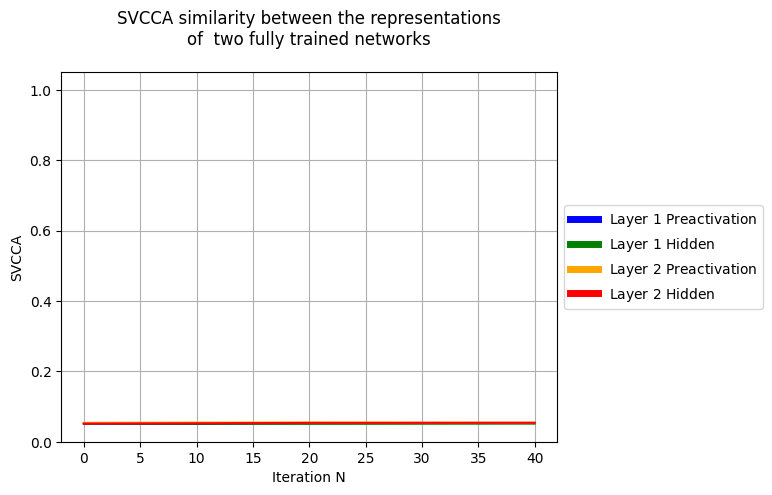

{'svcca_trajectory': {'data': {1: {'preactivation': [np.float64(0.05105568844684322),
     np.float64(0.05049781807192526),
     np.float64(0.05269358032967586),
     np.float64(0.05323015759607871),
     np.float64(0.05321780981465372)],
    'hidden': [np.float64(0.0523370616130324),
     np.float64(0.051266635362064085),
     np.float64(0.050860386412859136),
     np.float64(0.051167269779813083),
     np.float64(0.051445646395246444)]},
   2: {'preactivation': [np.float64(0.053573128758651424),
     np.float64(0.05430939381499391),
     np.float64(0.05455396460818248),
     np.float64(0.054220954646785904),
     np.float64(0.05402885435299577)],
    'hidden': [np.float64(0.05156155819457174),
     np.float64(0.052412383194906174),
     np.float64(0.053499180710600225),
     np.float64(0.05357418131730385),
     np.float64(0.053690604016445084)]}},
  'plot': {'title': 'SVCCA similarity between the representations\nof  two fully trained networks',
   'xlabel': 'Iteration N',
   'ylabe

In [18]:
##### 08/07 - Correlations between representations on CIFAR-10 : car-plane #####



date = '16_07_25'

dataset = 'teacher_(d-81_k-1_n-10e5)'

save_path = 'Post-processing/15_07_25/'
save_path_convergence_speed = save_path + 'Convergence speed/Dataset_' + dataset + '_statistical_results/'
save_path_normalized_convergence_speed = save_path + 'Normalized convergence speed/Dataset_' + dataset + '_statistical_results/'
save_path_max_accuracy = save_path + 'Maximum accuracy/Dataset_' + dataset + '_statistical_results/'
save_path_accuracy_trajectory = save_path + 'Accuracy trajectory/Dataset_' + dataset + '_statistical_results/'
save_path_loss_trajectory = save_path + 'Loss trajectory/Dataset_' + dataset + '_statistical_results/'
save_path_overlap = save_path + 'Overlaps/Dataset_' + dataset + '/'
save_path_covariances = save_path + 'Covariances/Dataset_' + dataset + '/'


os.makedirs(save_path_convergence_speed, exist_ok=True)
os.makedirs(save_path_normalized_convergence_speed, exist_ok=True)
os.makedirs(save_path_max_accuracy, exist_ok=True)
os.makedirs(save_path_accuracy_trajectory, exist_ok=True)
os.makedirs(save_path_loss_trajectory, exist_ok=True)
os.makedirs(save_path_overlap, exist_ok=True)
os.makedirs(save_path_covariances, exist_ok=True)


model_ref_1 = load_data_dictionnary(dataset + "_torch_model_(81+784.2+1)" + '_fully_trained_1', date)
model_ref_2 = load_data_dictionnary(dataset + "_torch_model_(81+784.2+1)" + '_fully_trained_2', date)
x_train = torch.load('Classifiers/' + date + '/' + date + '_' + dataset + '_torch_model_(81+784.2+1)_fully_trained_1/training_set.pt')
x_valid = torch.load('Classifiers/' + date + '/' + date + '_' + dataset + '_torch_model_(81+784.2+1)_fully_trained_1/validation_set.pt')

representation_SVCCA_trajectories(model_ref_1, model_ref_2, [x_valid[:5000], x_valid[5000:10000]], save_path=save_path_overlap, architecture='(81+784.2+1)', add_to_title=' two fully trained networks')
